In [1]:
import numpy as np
import pandas as pd
import sys,os

def load_files(batch):
    images = []
    labels = []
    for i in batch:
        print('Loading File: ' + i)
        x = np.load(i,encoding = 'latin1',allow_pickle=True).item()
        keys = x.keys()
        for key in keys:
            images.append(x[key][0])
            labels.append(x[key][1])
    return np.array(images),np.array(labels)

def get_feature(labels,feature):
    feature_values = []
    for i in labels:
        feature_values.append(i[feature])
    feature_values = np.array(feature_values)
    return feature_values

def get_cos_values(zenith,azimuth):
    cos1 = []
    cos2 = []
    cos3 = []
    for i,j in zip(zenith,azimuth):
        cos1.append(np.sin(i) * np.cos(j))
        cos2.append(np.sin(i) * np.sin(j))
        cos3.append(np.cos(i))
    return np.array(cos1),np.array(cos2),np.array(cos3)

In [2]:
file_path = '/fs/scratch/PAS1495/amedina/'
y = os.listdir(file_path+'processed_3D')

file_names = []

for i in y:
    file_names.append(file_path+'processed_3D/'+i)

file_names_batched = list(np.array_split(file_names,60))

In [3]:
images1,labels = load_files(file_names_batched[0])

Loading File: /fs/scratch/PAS1495/amedina/processed_3D/images_5958.npy
Loading File: /fs/scratch/PAS1495/amedina/processed_3D/images_207.npy
Loading File: /fs/scratch/PAS1495/amedina/processed_3D/images_5774.npy
Loading File: /fs/scratch/PAS1495/amedina/processed_3D/images_5256.npy
Loading File: /fs/scratch/PAS1495/amedina/processed_3D/images_4768.npy
Loading File: /fs/scratch/PAS1495/amedina/processed_3D/images_2519.npy
Loading File: /fs/scratch/PAS1495/amedina/processed_3D/images_4632.npy
Loading File: /fs/scratch/PAS1495/amedina/processed_3D/images_5356.npy
Loading File: /fs/scratch/PAS1495/amedina/processed_3D/images_4155.npy
Loading File: /fs/scratch/PAS1495/amedina/processed_3D/images_5633.npy
Loading File: /fs/scratch/PAS1495/amedina/processed_3D/images_4163.npy
Loading File: /fs/scratch/PAS1495/amedina/processed_3D/images_7039.npy
Loading File: /fs/scratch/PAS1495/amedina/processed_3D/images_6819.npy
Loading File: /fs/scratch/PAS1495/amedina/processed_3D/images_3831.npy
Loading

Loading File: /fs/scratch/PAS1495/amedina/processed_3D/images_2295.npy
Loading File: /fs/scratch/PAS1495/amedina/processed_3D/images_7850.npy
Loading File: /fs/scratch/PAS1495/amedina/processed_3D/images_5971.npy
Loading File: /fs/scratch/PAS1495/amedina/processed_3D/images_1227.npy
Loading File: /fs/scratch/PAS1495/amedina/processed_3D/images_4001.npy
Loading File: /fs/scratch/PAS1495/amedina/processed_3D/images_4573.npy
Loading File: /fs/scratch/PAS1495/amedina/processed_3D/images_2758.npy
Loading File: /fs/scratch/PAS1495/amedina/processed_3D/images_6983.npy
Loading File: /fs/scratch/PAS1495/amedina/processed_3D/images_3617.npy
Loading File: /fs/scratch/PAS1495/amedina/processed_3D/images_6790.npy
Loading File: /fs/scratch/PAS1495/amedina/processed_3D/images_4963.npy
Loading File: /fs/scratch/PAS1495/amedina/processed_3D/images_705.npy
Loading File: /fs/scratch/PAS1495/amedina/processed_3D/images_7135.npy
Loading File: /fs/scratch/PAS1495/amedina/processed_3D/images_1638.npy
Loading

In [4]:
images = images1[:,:,:,:,[0,7]]


zenith_values = get_feature(labels,1)
azimuth_values = get_feature(labels,2)

cos1,cos2,cos3 = get_cos_values(zenith_values,azimuth_values)

print(images.shape)

(5637, 60, 10, 19, 2)


In [5]:
import tensorflow as tf

import keras
from keras.models import Sequential,load_model, Model
from keras.layers import Dense, Dropout, Flatten, Input,InputLayer, Concatenate
from keras.layers import Conv3D, MaxPooling3D , GaussianNoise,BatchNormalization
from keras import backend as K
from sklearn.model_selection import train_test_split,KFold
from keras.layers import LeakyReLU,SpatialDropout3D,GaussianDropout,Lambda,UpSampling1D
from keras import regularizers

tf.distribute.Strategy

Using TensorFlow backend.


tensorflow.python.distribute.distribute_lib.StrategyV1

In [6]:
cos_values = np.array(list(zip(cos1,cos2,cos3)))

In [7]:
def get_data(images,values):
    x_train, x_test , y_train , y_test = train_test_split(images,values,test_size = 0.2 , random_state=42)
    return x_train,x_test,y_train,y_test

x_train,x_test,y_train,y_test = get_data(images,cos_values)

In [10]:
def loss_space_angle(y_true,y_pred):
    subtraction = tf.math.subtract(y_true,y_pred)
    y = tf.matrix_diag_part(K.dot(subtraction,K.transpose(subtraction)))
    loss = tf.math.reduce_mean(y)
    return loss


In [11]:
batch_size = 128
epochs=40
number_features = 2

img_heights,img_rows, img_cols = 60,10,19
input_shape = (img_rows, img_cols)

kernel = 3
kernel2 = 2

model1_input = Input(shape=(img_heights,img_rows,img_cols,number_features))

model1 = LeakyReLU(alpha = 0.01)(model1_input)
output1 = MaxPooling3D(kernel2,padding='same')(model1)
model1 = Conv3D(32,kernel,padding='same',kernel_regularizer=regularizers.l2(0.01))(output1)

model1 = LeakyReLU(alpha = 0.01)(model1)
output2 = MaxPooling3D(kernel2,padding='same')(model1)
model1 = Conv3D(32,kernel,padding='same',kernel_regularizer=regularizers.l2(0.01))(output2)

model1 = LeakyReLU(alpha = 0.01)(model1)
output3 = MaxPooling3D(kernel2,padding='same')(model1)
model1 = Conv3D(32,kernel,padding='same',kernel_regularizer=regularizers.l2(0.01))(output3)

cnn_model1 = Flatten()(model1_input)
cnn_model2 = Flatten()(model1)
cnn_model3 = Flatten()(output1)
cnn_model4 = Flatten()(output2)
cnn_model5 = Flatten()(output3)
cnn_model = Concatenate(axis=-1)([cnn_model1,
                                  cnn_model2,
                                  cnn_model3,
                                  cnn_model4,
                                  cnn_model5
                                 ])

cnn_model = Model(inputs=model1_input,outputs=cnn_model)
opt = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=1e-5, amsgrad=False)
cnn_model.compile(optimizer=opt , loss = loss_space_angle)

print(cnn_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 60, 10, 19, 2 0                                            
__________________________________________________________________________________________________
leaky_re_lu_4 (LeakyReLU)       (None, 60, 10, 19, 2 0           input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling3d_4 (MaxPooling3D)  (None, 30, 5, 10, 2) 0           leaky_re_lu_4[0][0]              
__________________________________________________________________________________________________
conv3d_4 (Conv3D)               (None, 30, 5, 10, 32 1760        max_pooling3d_4[0][0]            
__________________________________________________________________________________________________
leaky_re_l

In [12]:
input_new = Input(shape=(img_heights,img_rows,img_cols,number_features))

output = Lambda(lambda x: cnn_model(x))(input_new)

model = Dropout(0.5)(output)
model = Dense(512)(model)
model = LeakyReLU(alpha = 0.01)(model)
model = Dropout(0.5)(model)
model = Dense(512)(model)
model = LeakyReLU(alpha = 0.01)(model)

input_new_prime = Flatten()(input_new)
model = Concatenate(axis=-1)([model, input_new_prime])

predictions = Dense(3)(model)

model = Model(inputs=input_new,outputs=predictions)
opt = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=1e-5, amsgrad=False)
model.compile(optimizer=opt , loss = loss_space_angle)
print(model.summary())

W0730 16:52:52.452595 47211722089792 deprecation_wrapper.py:119] From /users/PAS1495/amedina/.local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0730 16:52:52.458456 47211722089792 deprecation.py:506] From /users/PAS1495/amedina/.local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 60, 10, 19, 2 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 36072)        0           input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 36072)        0           lambda_1[0][0]                   
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          18469376    dropout_1[0][0]                  
__________________________________________________________________________________________________
leaky_re_l

In [13]:
history=model.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=1,
                  validation_data=(x_test, y_test))

W0730 16:52:53.338496 47211722089792 deprecation_wrapper.py:119] From /users/PAS1495/amedina/.local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 4509 samples, validate on 1128 samples
Epoch 1/40
4509/4509 [==============================] - 6s 1ms/step - loss: 0.7387 - val_loss: 0.6836
Epoch 2/40
4509/4509 [==============================] - 5s 1ms/step - loss: 0.6161 - val_loss: 0.6145
Epoch 3/40
4509/4509 [==============================] - 5s 1ms/step - loss: 0.5450 - val_loss: 0.5538
Epoch 4/40
4509/4509 [==============================] - 5s 1ms/step - loss: 0.4804 - val_loss: 0.5005
Epoch 5/40
4509/4509 [==============================] - 5s 1ms/step - loss: 0.4233 - val_loss: 0.4538
Epoch 6/40
4509/4509 [==============================] - 5s 1ms/step - loss: 0.3786 - val_loss: 0.4185
Epoch 7/40
4509/4509 [==============================] - 5s 1ms/step - loss: 0.3406 - val_loss: 0.3907
Epoch 8/40
4509/4509 [==============================] - 5s 1ms/step - loss: 0.3042 - val_loss: 0.3729
Epoch 9/40
4509/4509 [==============================] - 5s 1ms/step - loss: 0.2830 - val_loss: 0.3376
Epoch 10/40
4509/4509 [===========

['loss', 'val_loss']


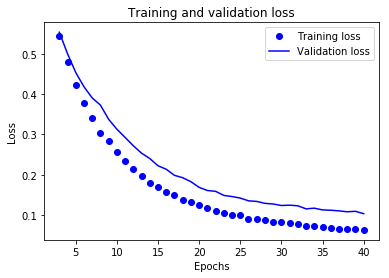

In [15]:
import matplotlib.pyplot as plt
history_dict = history.history
print(history_dict.keys())
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values)+1)

start = 2

plt.plot(epochs[start:len(epochs)],loss_values[start:len(loss_values)],'bo',label='Training loss')
plt.plot(epochs[start:len(epochs)],val_loss_values[start:len(val_loss_values)],'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [16]:
np.savetxt('file3.txt',[epochs,loss_values,val_loss_values])